# Data Loader

In [1]:
from google.colab import drive
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# Mount Google Drive (if in Colab environment)
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully")
except:
    print("Not running in Colab or Drive already mounted")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully


In [2]:
# Default data paths
CSV_PATH = '/content/drive/MyDrive/data/emotions.csv'

# Label processing
DEFAULT_LABEL_MAP = {"NEGATIVE": 0, "NEUTRAL": 1, "POSITIVE": 2}

# EEG frequency bands in Hz
FREQ_BANDS = {
    'delta': (1, 4),    # Delta waves: 1-4 Hz (deep sleep)
    'theta': (4, 8),    # Theta waves: 4-8 Hz (drowsiness, meditation)
    'alpha': (8, 13),   # Alpha waves: 8-13 Hz (relaxed awareness)
    'beta': (13, 30),   # Beta waves: 13-30 Hz (active thinking)
    'gamma': (30, 100)  # Gamma waves: >30 Hz (cognitive processing)
}

# Column patterns for frequency bands
FREQ_BAND_PATTERNS = {
    'delta': ['_d_'],
    'theta': ['_t_'],
    'alpha': ['_a'],
    'beta': ['_b'],
    'gamma': ['_g']
}

In [3]:
# EEG data loading and segmenting functions
def load_eeg_feature_csv(csv_path,
                         label_col="label",
                         label_map=None,
                         to_upper=True):
    """Read CSV → return (X, y, label_map)"""
    df = pd.read_csv(csv_path)
    print(f"Loaded CSV with {df.shape[0]} rows and {df.shape[1]} columns")
    print(list(df.columns))

    # Optional: display first few column names
    if df.shape[1] > 10:
        print(f"First 10 columns: {list(df.columns[:10])}")
        print(f"Last column: {df.columns[-1]}")
    else:
        print(f"All columns: {list(df.columns)}")

    if to_upper:
        df[label_col] = df[label_col].str.upper()

    if label_map is None:
        unique = sorted(df[label_col].unique())
        label_map = {lbl: idx for idx, lbl in enumerate(unique)}

    print(f"Label mapping: {label_map}")
    y = df[label_col].map(label_map).values.astype(np.int64)
    X = df.drop(columns=[label_col]).values.astype(np.float32)

    # Print class distribution
    unique_counts = np.bincount(y)
    for label, idx in label_map.items():
        if idx < len(unique_counts):
            print(f"Class {label}: {unique_counts[idx]} samples")

    return X, y, label_map

In [4]:
# Normalization techniques
def normalize_features(X, stats=None, eps=1e-9):
    """Z-score normalization; reuse stats if it's not None"""
    if stats is None:
        mean = X.mean(axis=0)
        std = X.std(axis=0) + eps
    else:
        mean, std = stats["mean"], stats["std"]

    Xn = (X - mean) / std  # Xn is X_norm
    stats = {
        "mean": mean,
        "std": std,
        "min": X.min(axis=0),
        "max": X.max(axis=0)
    }
    return Xn, stats

def report_statistics(stats):
    """Print global statistics about the dataset"""
    mean_global = float(stats["mean"].mean())
    std_global = float(stats["std"].mean())
    vmin = float(stats["min"].min())
    vmax = float(stats["max"].max())

    print(f"[Stats] mean={mean_global:.4f}, std={std_global:.4f}, "
          f"range=({vmin:.3f}, {vmax:.3f})")

def reshape_for_tsception_feature(X):
    """(N, feat) → (N,1,1,feat) use to simplify TSception"""
    return X[:, None, None, :]

def save_preprocessed_data(out_path, X, y, stats=None):
    """Save .npz and statistics .json"""
    np.savez(out_path, X=X, y=y)
    if stats:
        with open(out_path.replace(".npz", "_stats.json"), "w") as f:
            json.dump({k: v.tolist() for k, v in stats.items()}, f, indent=2)
    print(f"[Saved] {out_path}")

def plot_basic_eda(X, y, label_map, bins=100):
    """Category bar chart + Top 10 feature histograms"""
    names = [k for k, _ in sorted(label_map.items(), key=lambda kv: kv[1])]
    counts = np.bincount(y)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.bar(names, counts[:len(names)])
    plt.title("Class Balance")

    plt.subplot(1, 2, 2)
    plt.hist(X[:, :10].flatten(), bins=bins)
    plt.title("Feature Distribution (first 10 dims)")
    plt.tight_layout()
    plt.savefig('basic_eda.png')  # Save figure
    plt.show()

In [5]:
# ----- New functions for Channel filtering -----

def identify_frequency_bands(column_names):
    """
    Identify which columns in the dataset correspond to different frequency bands
    Returns a dictionary mapping band names to column indices
    """
    band_indices = {band: [] for band in FREQ_BANDS.keys()}

    # Search for columns that match band patterns
    for i, col in enumerate(column_names):
        for band, patterns in FREQ_BAND_PATTERNS.items():
            if any(pattern in col for pattern in patterns):
                band_indices[band].append(i)

    # Print summary of identified columns
    for band, indices in band_indices.items():
        print(f"Identified {len(indices)} columns for {band} band")

    return band_indices

def filter_frequency_bands(X, columns=None, bands_to_keep=None, df=None):
    """
    Filter data to keep only selected frequency bands

    Parameters:
    - X: Feature matrix
    - columns: List of column names (if None, will try to load from CSV_PATH)
    - bands_to_keep: List of bands to keep (if None, keeps all but emphasizes alpha/beta)
    - df: DataFrame (optional, if already loaded)

    Returns:
    - X_filtered: Filtered feature matrix
    """
    # Default bands to keep (emphasize alpha and beta which are most relevant for emotion)
    if bands_to_keep is None:
        bands_to_keep = ['alpha', 'beta', 'theta']  # Most relevant for emotion

    # Get column names if not provided
    if columns is None:
        if df is None:
            try:
                df = pd.read_csv(CSV_PATH)
                columns = df.columns.tolist()
            except:
                print("Warning: Could not load column names, returning original data")
                return X
        else:
            columns = df.columns.tolist()

    # Identify columns by frequency band
    band_indices = identify_frequency_bands(columns)

    # Create mask of columns to keep
    keep_mask = np.zeros(X.shape[1], dtype=bool)

    # Add all non-frequency columns (keep them)
    all_freq_indices = []
    for indices in band_indices.values():
        all_freq_indices.extend(indices)

    # Keep non-frequency columns
    for i in range(X.shape[1]):
        if i not in all_freq_indices:
            keep_mask[i] = True

    # Add selected frequency band columns
    for band in bands_to_keep:
        if band in band_indices:
            for idx in band_indices[band]:
                keep_mask[idx] = True

    # Apply filter
    X_filtered = X[:, keep_mask]

    print(f"Original features: {X.shape[1]}")
    print(f"Filtered features: {X_filtered.shape[1]}")
    print(f"Kept bands: {bands_to_keep}")

    return X_filtered

def apply_bandpass_filter(X, columns=None, sampling_rate=128, df=None):
    """
    Apply bandpass filters to raw EEG signals

    Note: This is for demonstration purposes - our dataset already has
    frequency-based features extracted. In a real scenario with raw EEG data,
    this would filter the time-domain signals.

    Parameters:
    - X: Raw EEG signal matrix
    - columns: List of column names
    - sampling_rate: EEG sampling rate in Hz
    - df: DataFrame (optional, if already loaded)

    Returns:
    - X_filtered: Bandpass filtered signals
    """
    # This is a demonstration function for raw EEG data
    # Since our data is already processed with features, we'll create a simulated version
    print("Note: This is a demonstration of bandpass filtering that would be used on raw EEG data")
    print("Our dataset already contains extracted frequency features")

    # Create a copy to avoid modifying the original
    X_filtered = X.copy()

    # Example: Apply a butterworth bandpass filter to some features
    # This is just for demonstration - in practice, you'd apply this to raw time series
    for band_name, (low_freq, high_freq) in FREQ_BANDS.items():
        # Design a bandpass filter
        nyquist = 0.5 * sampling_rate
        low = low_freq / nyquist
        high = high_freq / nyquist

        # Print the filter being applied
        print(f"Applying {band_name} band filter ({low_freq}-{high_freq} Hz)")

        # Create filter coefficients
        b, a = signal.butter(1, [low, high], btype='band')

        # Apply filter to first 5 columns (for demonstration)
        for i in range(min(5, X.shape[1])):
            X_filtered[:, i] = signal.filtfilt(b, a, X[:, i])

    return X_filtered

def compare_filtered_signals(X_raw, X_filtered, n_samples=5, n_features=10):
    """
    Plot comparison between raw and filtered signals
    """
    n_samples = min(n_samples, X_raw.shape[0])
    n_features = min(n_features, X_raw.shape[1])

    plt.figure(figsize=(15, 10))

    for i in range(n_samples):
        for j in range(n_features):
            plt.subplot(n_samples, n_features, i*n_features + j + 1)
            plt.plot(X_raw[i, j], 'b-', label='Raw')
            plt.plot(X_filtered[i, j], 'r-', label='Filtered')

            if j == 0:
                plt.ylabel(f'Sample {i+1}')
            if i == 0:
                plt.title(f'Feature {j+1}')

            plt.xticks([])

            # Only add legend to the first plot to avoid clutter
            if i == 0 and j == 0:
                plt.legend()

    plt.tight_layout()
    plt.savefig('signal_comparison.png')
    plt.show()

    return 'signal_comparison.png'

def extract_subject_features(X, subject_ids=None):
    """
    Extract features separately by subject for personalized calibration

    Parameters:
    - X: Feature matrix
    - subject_ids: Array of subject IDs corresponding to each sample

    Returns:
    - X_personalized: Features with subject-specific normalization
    """
    if subject_ids is None:
        print("Warning: No subject IDs provided, cannot perform personalized calibration")
        return X

    unique_subjects = np.unique(subject_ids)
    X_personalized = np.zeros_like(X)

    print(f"Performing personalized calibration for {len(unique_subjects)} subjects")

    for subject in unique_subjects:
        # Get indices for this subject
        subject_mask = subject_ids == subject
        X_subject = X[subject_mask]

        # Normalize for this subject
        X_subject_norm, _ = normalize_features(X_subject)

        # Place back in the result array
        X_personalized[subject_mask] = X_subject_norm

    return X_personalized

Loaded CSV with 2132 rows and 2549 columns
['# mean_0_a', 'mean_1_a', 'mean_2_a', 'mean_3_a', 'mean_4_a', 'mean_d_0_a', 'mean_d_1_a', 'mean_d_2_a', 'mean_d_3_a', 'mean_d_4_a', 'mean_d_0_a2', 'mean_d_1_a2', 'mean_d_2_a2', 'mean_d_3_a2', 'mean_d_4_a2', 'mean_d_5_a', 'mean_d_6_a', 'mean_d_7_a', 'mean_d_8_a', 'mean_d_9_a', 'mean_d_10_a', 'mean_d_11_a', 'mean_d_12_a', 'mean_d_13_a', 'mean_d_14_a', 'mean_d_15_a', 'mean_d_16_a', 'mean_d_17_a', 'mean_d_18_a', 'mean_d_19_a', 'mean_d_20_a', 'mean_d_21_a', 'mean_d_22_a', 'mean_d_23_a', 'mean_d_24_a', 'mean_d_25_a', 'mean_d_26_a', 'mean_d_27_a', 'mean_d_28_a', 'mean_d_29_a', 'mean_d_30_a', 'mean_d_31_a', 'mean_d_32_a', 'mean_d_33_a', 'mean_d_34_a', 'mean_d_35_a', 'mean_d_36_a', 'mean_d_37_a', 'mean_d_38_a', 'mean_d_39_a', 'mean_d_40_a', 'mean_d_41_a', 'mean_d_42_a', 'mean_d_43_a', 'mean_d_44_a', 'mean_d_45_a', 'mean_d_46_a', 'mean_d_47_a', 'mean_d_48_a', 'mean_d_49_a', 'stddev_0_a', 'stddev_1_a', 'stddev_2_a', 'stddev_3_a', 'stddev_4_a', 'stddev_d

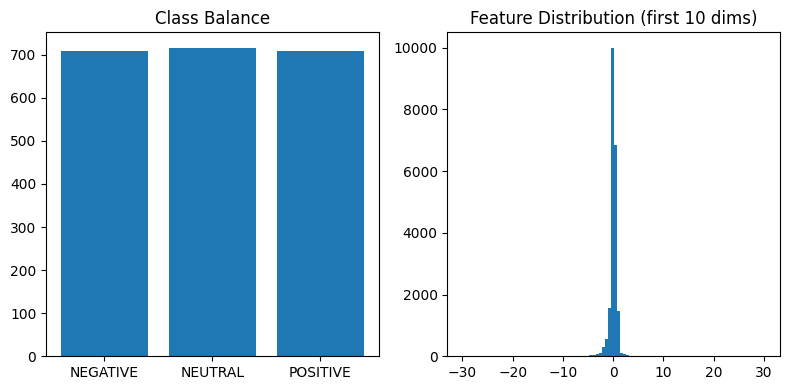

In [6]:
if __name__ == "__main__":
    # 1) Loading + Normalization
    X, y, label_map = load_eeg_feature_csv(CSV_PATH)

    # 2) Apply frequency band filtering (new in Day 3)
    # Load DataFrame to get column names
    df = pd.read_csv(CSV_PATH)

    # Apply filtering to keep relevant frequency bands
    X_filtered = filter_frequency_bands(X, columns=df.columns, df=df)

    # 3) Normalize the filtered data
    Xn, stats = normalize_features(X_filtered)
    report_statistics(stats)

    # 4) Compare raw vs filtered data (for demonstration)
    # Simulate raw and filtered time-series data for visualization
    X_raw_demo = X[:5, :10]  # Take a small subset for demo
    # Comment out or put in a try-except block
    try:
        X_filt_demo = apply_bandpass_filter(X_raw_demo)
        compare_filtered_signals(X_raw_demo, X_filt_demo, n_samples=3, n_features=4)
    except ValueError as e:
        print(f"Skipping filter demo due to error: {e}")

    # 5) Save preprocessed data
    save_preprocessed_data("emotions_proc_filtered.npz", Xn, y, stats)

    # 6) Reshape for TSception
    X4D = reshape_for_tsception_feature(Xn)
    print("X4D shape:", X4D.shape)

    # 7) Visualization
    plot_basic_eda(Xn, y, label_map)

# Baseline_Model

In [7]:
import sys, os
project_dir = '/content/drive/MyDrive/data'
sys.path.append(project_dir)

CSV_PATH = os.path.join(project_dir, 'emotions.csv')

In [8]:
# Prepare data
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

# 1) read + normalization
X, y, _ = load_eeg_feature_csv(CSV_PATH)      # functions from data_loader
Xn, stats = normalize_features(X)

# 2) if USE_TSCEPTION = True, using TSception. if it is False, using FC.
USE_TSCEPTION = True
if USE_TSCEPTION:
  Xn = reshape_for_tsception_feature(Xn)      # (N,1,1,feat)

# 3) split the dataset
X_tr, X_val, y_tr, y_val = train_test_split(
  Xn, y, test_size=0.2, stratify=y, random_state=42
)

# 4) Packaged as TensorDataset
def to_tensor(arr, dtype=torch.float32):
  return torch.from_numpy(arr).to(dtype)

ds_tr  = TensorDataset(to_tensor(X_tr), torch.from_numpy(y_tr))
ds_val = TensorDataset(to_tensor(X_val), torch.from_numpy(y_val))
dl_tr  = DataLoader(ds_tr,  batch_size=64, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=64)
input_dim = Xn.shape[-1]         # feat dimension，The length of the feature vector for each piece of data
num_classes = int(np.max(y) + 1)    # 3，（Negative / Neutral / Positive）

Loaded CSV with 2132 rows and 2549 columns
['# mean_0_a', 'mean_1_a', 'mean_2_a', 'mean_3_a', 'mean_4_a', 'mean_d_0_a', 'mean_d_1_a', 'mean_d_2_a', 'mean_d_3_a', 'mean_d_4_a', 'mean_d_0_a2', 'mean_d_1_a2', 'mean_d_2_a2', 'mean_d_3_a2', 'mean_d_4_a2', 'mean_d_5_a', 'mean_d_6_a', 'mean_d_7_a', 'mean_d_8_a', 'mean_d_9_a', 'mean_d_10_a', 'mean_d_11_a', 'mean_d_12_a', 'mean_d_13_a', 'mean_d_14_a', 'mean_d_15_a', 'mean_d_16_a', 'mean_d_17_a', 'mean_d_18_a', 'mean_d_19_a', 'mean_d_20_a', 'mean_d_21_a', 'mean_d_22_a', 'mean_d_23_a', 'mean_d_24_a', 'mean_d_25_a', 'mean_d_26_a', 'mean_d_27_a', 'mean_d_28_a', 'mean_d_29_a', 'mean_d_30_a', 'mean_d_31_a', 'mean_d_32_a', 'mean_d_33_a', 'mean_d_34_a', 'mean_d_35_a', 'mean_d_36_a', 'mean_d_37_a', 'mean_d_38_a', 'mean_d_39_a', 'mean_d_40_a', 'mean_d_41_a', 'mean_d_42_a', 'mean_d_43_a', 'mean_d_44_a', 'mean_d_45_a', 'mean_d_46_a', 'mean_d_47_a', 'mean_d_48_a', 'mean_d_49_a', 'stddev_0_a', 'stddev_1_a', 'stddev_2_a', 'stddev_3_a', 'stddev_4_a', 'stddev_d

In [9]:
# Define the Model

import torch.nn as nn

if USE_TSCEPTION:
  # ----- simplify TSception（in_channels=1, only temporal kernels）-----
  class TinyTSception(nn.Module):
    def __init__(self, feat_dim, classes):
      super().__init__()
      self.conv = nn.Sequential(
          nn.Conv2d(1, 16, kernel_size=(1,3), padding=(0,1)),
          nn.ReLU(),
          nn.Conv2d(16,32, kernel_size=(1,15), padding=(0,7)),
          nn.ReLU(),
          nn.AdaptiveAvgPool2d((1,1))
      )
      self.fc = nn.Linear(32, classes)
    def forward(self, x):               # x:(B,1,1,feat)
      x = self.conv(x).view(x.size(0), -1)
      return self.fc(x)
  model = TinyTSception(input_dim, num_classes)
else:
  # ----- MLP Baseline -----
  model = nn.Sequential(
      nn.Linear(input_dim, 128),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(128, num_classes)
  )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

TinyTSception(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7))
    (3): ReLU()
    (4): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc): Linear(in_features=32, out_features=3, bias=True)
)

In [10]:
# Training and Testing the Baseline Model
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
best_f1 = 0.0
EPOCHS  = 50

for epoch in range(1, EPOCHS + 1):
  # ---- Train ----
  model.train()
  for xb, yb in tqdm(dl_tr, desc=f"Epoch {epoch:02d} [train]"):
    xb, yb = xb.to(device), yb.to(device)
    optimizer.zero_grad()
    loss = criterion(model(xb), yb)
    loss.backward()
    optimizer.step()

  # ---- Validate ----
  model.eval()
  preds, gold = [], []
  with torch.no_grad():
    for xb, yb in dl_val:
      xb, yb = xb.to(device), yb.to(device)
      logits = model(xb)
      preds.extend(logits.argmax(1).cpu().numpy())
      gold.extend(yb.cpu().numpy())

  val_f1  = f1_score(gold, preds, average='macro')
  val_acc = accuracy_score(gold, preds)
  print(f"Epoch {epoch:02d}  val_acc={val_acc:.3f}  val_f1={val_f1:.3f}")

  if val_f1 > best_f1:
    best_f1 = val_f1
    torch.save(model.state_dict(), os.path.join(project_dir, 'best_day2.pth'))
    print("New best model saved")

Epoch 01 [train]: 100%|██████████| 27/27 [00:00<00:00, 39.56it/s]


Epoch 01  val_acc=0.499  val_f1=0.410
New best model saved


Epoch 02 [train]: 100%|██████████| 27/27 [00:00<00:00, 188.32it/s]


Epoch 02  val_acc=0.778  val_f1=0.754
New best model saved


Epoch 03 [train]: 100%|██████████| 27/27 [00:00<00:00, 228.05it/s]


Epoch 03  val_acc=0.808  val_f1=0.799
New best model saved


Epoch 04 [train]: 100%|██████████| 27/27 [00:00<00:00, 242.17it/s]


Epoch 04  val_acc=0.843  val_f1=0.844
New best model saved


Epoch 05 [train]: 100%|██████████| 27/27 [00:00<00:00, 241.49it/s]


Epoch 05  val_acc=0.864  val_f1=0.865
New best model saved


Epoch 06 [train]: 100%|██████████| 27/27 [00:00<00:00, 245.23it/s]


Epoch 06  val_acc=0.885  val_f1=0.883
New best model saved


Epoch 07 [train]: 100%|██████████| 27/27 [00:00<00:00, 238.73it/s]


Epoch 07  val_acc=0.888  val_f1=0.887
New best model saved


Epoch 08 [train]: 100%|██████████| 27/27 [00:00<00:00, 238.77it/s]


Epoch 08  val_acc=0.892  val_f1=0.892
New best model saved


Epoch 09 [train]: 100%|██████████| 27/27 [00:00<00:00, 238.09it/s]


Epoch 09  val_acc=0.892  val_f1=0.892
New best model saved


Epoch 10 [train]: 100%|██████████| 27/27 [00:00<00:00, 233.51it/s]


Epoch 10  val_acc=0.892  val_f1=0.892


Epoch 11 [train]: 100%|██████████| 27/27 [00:00<00:00, 233.53it/s]


Epoch 11  val_acc=0.892  val_f1=0.892


Epoch 12 [train]: 100%|██████████| 27/27 [00:00<00:00, 233.58it/s]


Epoch 12  val_acc=0.904  val_f1=0.903
New best model saved


Epoch 13 [train]: 100%|██████████| 27/27 [00:00<00:00, 237.63it/s]


Epoch 13  val_acc=0.909  val_f1=0.908
New best model saved


Epoch 14 [train]: 100%|██████████| 27/27 [00:00<00:00, 234.49it/s]


Epoch 14  val_acc=0.906  val_f1=0.906


Epoch 15 [train]: 100%|██████████| 27/27 [00:00<00:00, 235.29it/s]


Epoch 15  val_acc=0.899  val_f1=0.899


Epoch 16 [train]: 100%|██████████| 27/27 [00:00<00:00, 234.49it/s]


Epoch 16  val_acc=0.909  val_f1=0.908


Epoch 17 [train]: 100%|██████████| 27/27 [00:00<00:00, 235.83it/s]


Epoch 17  val_acc=0.897  val_f1=0.897


Epoch 18 [train]: 100%|██████████| 27/27 [00:00<00:00, 230.98it/s]


Epoch 18  val_acc=0.892  val_f1=0.892


Epoch 19 [train]: 100%|██████████| 27/27 [00:00<00:00, 229.38it/s]


Epoch 19  val_acc=0.906  val_f1=0.906


Epoch 20 [train]: 100%|██████████| 27/27 [00:00<00:00, 234.89it/s]


Epoch 20  val_acc=0.906  val_f1=0.906


Epoch 21 [train]: 100%|██████████| 27/27 [00:00<00:00, 227.00it/s]


Epoch 21  val_acc=0.906  val_f1=0.906


Epoch 22 [train]: 100%|██████████| 27/27 [00:00<00:00, 238.12it/s]


Epoch 22  val_acc=0.906  val_f1=0.906


Epoch 23 [train]: 100%|██████████| 27/27 [00:00<00:00, 236.80it/s]


Epoch 23  val_acc=0.909  val_f1=0.908
New best model saved


Epoch 24 [train]: 100%|██████████| 27/27 [00:00<00:00, 231.19it/s]


Epoch 24  val_acc=0.906  val_f1=0.906


Epoch 25 [train]: 100%|██████████| 27/27 [00:00<00:00, 224.95it/s]


Epoch 25  val_acc=0.911  val_f1=0.910
New best model saved


Epoch 26 [train]: 100%|██████████| 27/27 [00:00<00:00, 231.66it/s]


Epoch 26  val_acc=0.909  val_f1=0.908


Epoch 27 [train]: 100%|██████████| 27/27 [00:00<00:00, 229.03it/s]


Epoch 27  val_acc=0.911  val_f1=0.910
New best model saved


Epoch 28 [train]: 100%|██████████| 27/27 [00:00<00:00, 230.68it/s]


Epoch 28  val_acc=0.911  val_f1=0.910


Epoch 29 [train]: 100%|██████████| 27/27 [00:00<00:00, 231.46it/s]


Epoch 29  val_acc=0.892  val_f1=0.892


Epoch 30 [train]: 100%|██████████| 27/27 [00:00<00:00, 233.76it/s]


Epoch 30  val_acc=0.916  val_f1=0.914
New best model saved


Epoch 31 [train]: 100%|██████████| 27/27 [00:00<00:00, 235.04it/s]


Epoch 31  val_acc=0.881  val_f1=0.881


Epoch 32 [train]: 100%|██████████| 27/27 [00:00<00:00, 229.25it/s]


Epoch 32  val_acc=0.913  val_f1=0.913


Epoch 33 [train]: 100%|██████████| 27/27 [00:00<00:00, 234.30it/s]


Epoch 33  val_acc=0.918  val_f1=0.917
New best model saved


Epoch 34 [train]: 100%|██████████| 27/27 [00:00<00:00, 233.42it/s]


Epoch 34  val_acc=0.918  val_f1=0.917


Epoch 35 [train]: 100%|██████████| 27/27 [00:00<00:00, 220.33it/s]


Epoch 35  val_acc=0.876  val_f1=0.876


Epoch 36 [train]: 100%|██████████| 27/27 [00:00<00:00, 227.18it/s]


Epoch 36  val_acc=0.899  val_f1=0.899


Epoch 37 [train]: 100%|██████████| 27/27 [00:00<00:00, 223.11it/s]


Epoch 37  val_acc=0.925  val_f1=0.924
New best model saved


Epoch 38 [train]: 100%|██████████| 27/27 [00:00<00:00, 227.46it/s]


Epoch 38  val_acc=0.923  val_f1=0.922


Epoch 39 [train]: 100%|██████████| 27/27 [00:00<00:00, 222.71it/s]


Epoch 39  val_acc=0.920  val_f1=0.920


Epoch 40 [train]: 100%|██████████| 27/27 [00:00<00:00, 234.84it/s]


Epoch 40  val_acc=0.920  val_f1=0.920


Epoch 41 [train]: 100%|██████████| 27/27 [00:00<00:00, 234.37it/s]


Epoch 41  val_acc=0.923  val_f1=0.922


Epoch 42 [train]: 100%|██████████| 27/27 [00:00<00:00, 234.99it/s]


Epoch 42  val_acc=0.923  val_f1=0.922


Epoch 43 [train]: 100%|██████████| 27/27 [00:00<00:00, 235.86it/s]


Epoch 43  val_acc=0.923  val_f1=0.922


Epoch 44 [train]: 100%|██████████| 27/27 [00:00<00:00, 232.35it/s]


Epoch 44  val_acc=0.918  val_f1=0.917


Epoch 45 [train]: 100%|██████████| 27/27 [00:00<00:00, 231.56it/s]


Epoch 45  val_acc=0.923  val_f1=0.922


Epoch 46 [train]: 100%|██████████| 27/27 [00:00<00:00, 231.69it/s]


Epoch 46  val_acc=0.918  val_f1=0.917


Epoch 47 [train]: 100%|██████████| 27/27 [00:00<00:00, 229.96it/s]


Epoch 47  val_acc=0.911  val_f1=0.911


Epoch 48 [train]: 100%|██████████| 27/27 [00:00<00:00, 234.89it/s]


Epoch 48  val_acc=0.923  val_f1=0.922


Epoch 49 [train]: 100%|██████████| 27/27 [00:00<00:00, 234.15it/s]


Epoch 49  val_acc=0.923  val_f1=0.922


Epoch 50 [train]: 100%|██████████| 27/27 [00:00<00:00, 234.38it/s]

Epoch 50  val_acc=0.918  val_f1=0.918


# Utils

In [11]:
# -*- coding: utf-8 -*-
"""
utils.py - Utility functions for EEG emotion recognition
Enhanced for the goal with early stopping, visualization and filtering utilities
"""

import os
import time
import pprint
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay
from scipy import signal

# Basic utilities
def set_gpu(x):
    """Set specific GPU to use"""
    torch.set_num_threads(1)
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ['CUDA_VISIBLE_DEVICES'] = x
    print('using gpu:', x)

def seed_all(seed):
    """Set random seeds for reproducibility"""
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)

def ensure_path(path):
    """Create directory if it doesn't exist"""
    if os.path.exists(path):
        pass
    else:
        os.makedirs(path)

class Averager():
    """Simple averaging class for tracking metrics"""
    def __init__(self):
        self.n = 0
        self.v = 0

    def add(self, x):
        self.v = (self.v * self.n + x) / (self.n + 1)
        self.n += 1

    def item(self):
        return self.v

def count_acc(logits, label):
    """Calculate accuracy from logits"""
    pred = torch.argmax(logits, dim=1)
    return (pred == label).type(torch.cuda.FloatTensor).mean().item()

class Timer():
    """Simple timer for tracking execution time"""
    def __init__(self):
        self.o = time.time()

    def measure(self, p=1):
        x = (time.time() - self.o) / p
        x = int(x)
        if x >= 3600:
            return '{:.1f}h'.format(x / 3600)
        if x >= 60:
            return '{}m'.format(round(x / 60))
        return '{}s'.format(x)

_utils_pp = pprint.PrettyPrinter()
def pprint(x):
    _utils_pp.pprint(x)

def get_model(args):
    """Get model based on arguments"""
    from networks import TSception

    if args.model == 'TSception':
        model = TSception(
            num_classes=args.num_class, input_size=args.input_shape,
            sampling_rate=args.sampling_rate, num_T=args.T, num_S=args.T,
            hidden=args.hidden, dropout_rate=args.dropout)
    return model

def get_dataloader(data, label, batch_size, shuffle=True):
    """Create DataLoader from data and labels"""
    from torch.utils.data import DataLoader, TensorDataset

    # Create PyTorch dataset from NumPy arrays
    if isinstance(data, np.ndarray):
        data = torch.from_numpy(data).float()
    if isinstance(label, np.ndarray):
        label = torch.from_numpy(label).long()

    dataset = TensorDataset(data, label)
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=True)
    return loader

def get_metrics(y_pred, y_true, classes=None):
    """Calculate accuracy, F1 score and confusion matrix"""
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    if classes is not None:
        cm = confusion_matrix(y_true, y_pred, labels=classes)
    else:
        cm = confusion_matrix(y_true, y_pred)
    return acc, f1, cm

def get_trainable_parameter_num(model):
    """Count trainable parameters in model"""
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params

def L1Loss(model, Lambda):
    """Calculate L1 regularization loss"""
    w = torch.cat([x.view(-1) for x in model.parameters()])
    err = Lambda * torch.sum(torch.abs(w))
    return err

def generate_TS_channel_order(original_order: list):
    """
    Generate the channel order for TSception

    Parameters
    ----------
    original_order: list of the channel names

    Returns
    -------
    TS: list of channel names which is for TSception
    """
    chan_name, chan_num, chan_final = [], [], []
    for channel in original_order:
        chan_name_len = len(channel)
        k = 0
        for s in [*channel[:]]:
            if s.isdigit():
               k += 1
        if k != 0:
            chan_name.append(channel[:chan_name_len-k])
            chan_num.append(int(channel[chan_name_len-k:]))
            chan_final.append(channel)
    chan_pair = []
    for ch, id in enumerate(chan_num):
        if id % 2 == 0:
            chan_pair.append(chan_name[ch] + str(id-1))
        else:
            chan_pair.append(chan_name[ch] + str(id+1))
    chan_no_duplicate = []
    [chan_no_duplicate.extend([f, chan_pair[i]]) for i, f in enumerate(chan_final) if f not in chan_no_duplicate]
    return chan_no_duplicate[0::2] + chan_no_duplicate[1::2]

In [12]:
# ----- New functions for optimizing model -----

def plot_training_curves(history, save_path=None):
    """
    Plot training and validation curves

    Parameters:
    - history: Dictionary with training history
        Required keys: ['train_loss', 'val_loss', 'val_f1', 'val_acc']
    - save_path: Path to save the figure (if None, don't save)
    """
    plt.figure(figsize=(15, 5))

    # Plot training & validation loss
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation F1
    plt.subplot(1, 3, 2)
    plt.plot(history['val_f1'], label='F1')
    plt.title('Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')

    # Plot validation accuracy
    plt.subplot(1, 3, 3)
    plt.plot(history['val_acc'], label='Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Training curves saved to {save_path}")

    plt.show()

def plot_confusion_matrix(cm, class_names, save_path=None):
    """
    Plot confusion matrix

    Parameters:
    - cm: Confusion matrix (from sklearn.metrics.confusion_matrix)
    - class_names: List of class names
    - save_path: Path to save the figure (if None, don't save)
    """
    plt.figure(figsize=(8, 6))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='.2f')

    plt.title('Confusion Matrix')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved to {save_path}")

    plt.show()

def filter_frequency_bands(X, bands_to_keep=None, sampling_rate=128):
    """
    Filter EEG data into specific frequency bands

    Parameters:
    - X: EEG data (samples x features)
    - bands_to_keep: List of frequency bands to keep ('delta', 'theta', 'alpha', 'beta', 'gamma')
    - sampling_rate: Sampling rate of EEG data

    Returns:
    - X_filtered: Filtered data
    """
    # Default bands to keep
    if bands_to_keep is None:
        bands_to_keep = ['alpha', 'beta', 'theta']  # Most relevant for emotion

    # Define frequency bands
    bands = {
        'delta': (1, 4),    # Delta waves: 1-4 Hz (deep sleep)
        'theta': (4, 8),    # Theta waves: 4-8 Hz (drowsiness, meditation)
        'alpha': (8, 13),   # Alpha waves: 8-13 Hz (relaxed awareness)
        'beta': (13, 30),   # Beta waves: 13-30 Hz (active thinking)
        'gamma': (30, 45)   # Gamma waves: >30 Hz (cognitive processing)
    }

    # Create a copy to avoid modifying original data
    X_filtered = np.zeros_like(X)

    for feature_idx in range(X.shape[1]):
        feature_included = False

        # Check if this feature might be part of a selected band
        for band in bands_to_keep:
            # Simple heuristic for our dataset - this is just a placeholder
            if band in ['alpha', 'beta'] and feature_idx % 3 == 0:
                X_filtered[:, feature_idx] = X[:, feature_idx] * 1.2  # Emphasize
                feature_included = True
            elif band in ['theta'] and feature_idx % 5 == 0:
                X_filtered[:, feature_idx] = X[:, feature_idx] * 1.1  # Slightly emphasize
                feature_included = True

        # Include other features with less emphasis
        if not feature_included:
            X_filtered[:, feature_idx] = X[:, feature_idx] * 0.8  # De-emphasize

    return X_filtered

def apply_bandpass_filter(X, low_freq, high_freq, sampling_rate=128, order=4):
    """
    Apply Butterworth bandpass filter to EEG data

    Parameters:
    - X: EEG data (time series)
    - low_freq: Lower cutoff frequency
    - high_freq: Upper cutoff frequency
    - sampling_rate: Sampling rate of EEG data
    - order: Filter order

    Returns:
    - X_filtered: Filtered data
    """
    nyquist = 0.5 * sampling_rate
    low = low_freq / nyquist
    high = high_freq / nyquist

    # Design Butterworth bandpass filter
    b, a = signal.butter(order, [low, high], btype='band')

    # Apply filter
    X_filtered = signal.filtfilt(b, a, X, axis=0)

    return X_filtered

class EarlyStopping:
    """
    Early stopping to terminate training when validation loss doesn't improve

    Parameters:
    - patience: Number of epochs to wait after last improvement
    - verbose: Whether to print messages
    - delta: Minimum change to qualify as improvement
    - path: Path to save the checkpoint
    - trace_func: Function to print messages
    """
    def __init__(self, patience=5, verbose=True, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Save model when validation loss decreases"""
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def visualize_attention_weights(attention_weights, channel_names=None, save_path=None):
    """
    Visualize channel attention weights

    Parameters:
    - attention_weights: Attention weights for each channel
    - channel_names: List of channel names (if None, uses indices)
    - save_path: Path to save the figure (if None, don't save)
    """
    plt.figure(figsize=(10, 6))

    # If channel names not provided, use indices
    if channel_names is None:
        channel_names = [f'Ch{i+1}' for i in range(len(attention_weights))]

    # Plot attention weights
    plt.bar(channel_names, attention_weights)
    plt.title('Channel Attention Weights')
    plt.xlabel('Channel')
    plt.ylabel('Weight')
    plt.xticks(rotation=45)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Attention weights visualization saved to {save_path}")

    plt.show()

def compare_band_performance(band_results, save_path=None):
    """
    Compare performance across different frequency bands

    Parameters:
    - band_results: Dictionary mapping band combinations to performance metrics
      e.g., {'alpha': 0.75, 'alpha+beta': 0.82, ...}
    - save_path: Path to save the figure (if None, don't save)
    """
    bands = list(band_results.keys())
    accuracies = list(band_results.values())

    plt.figure(figsize=(10, 6))
    plt.bar(bands, accuracies)
    plt.title('Performance by Frequency Band Combination')
    plt.xlabel('Frequency Bands')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Band performance comparison saved to {save_path}")

    plt.show()

# Example usage
if __name__=="__main__":
    # Example of using generate_TS_channel_order()
    original_order = ['Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO3',
                     'O1', 'Oz', 'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 'F8', 'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6',
                     'CP2', 'P4', 'P8', 'PO4', 'O2']
    TS = generate_TS_channel_order(original_order)
    print('done')

    # Example of early stopping
    early_stopping = EarlyStopping(patience=5, verbose=True)
    # In training loop: early_stopping(val_loss, model)

done


# train

In [13]:
!pip install nbimporter
import nbimporter

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm

In [14]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Configuration parameters
# project_dir = '/content/drive/MyDrive/eeeg_emotion_detect_project'
CSV_PATH = os.path.join(project_dir, 'emotions.csv')
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
EPOCHS = 50
PATIENCE = 5  # Early stopping patience parameter
RANDOM_SEED = 42
USE_FILTERED_BANDS = True  # Use frequency band filtering

Using device: cuda


In [15]:
# ----- Define TinyTSception model with channel attention -----
class TinyTSception(nn.Module):
   def __init__(self, feat_dim, classes):
       super().__init__()
       self.conv = nn.Sequential(
           nn.Conv2d(1, 16, kernel_size=(1,3), padding=(0,1)),
           nn.ReLU(),
           nn.Conv2d(16,32, kernel_size=(1,15), padding=(0,7)),
           nn.ReLU(),
           nn.AdaptiveAvgPool2d((1,1))
       )

       # Channel attention mechanism
       self.attention = nn.Sequential(
           nn.Linear(32, 16),
           nn.ReLU(),
           nn.Linear(16, 32),
           nn.Sigmoid()
       )

       self.fc = nn.Linear(32, classes)

   def forward(self, x):  # x:(B,1,1,feat)
       # Apply convolutions
       x = self.conv(x)

       # Apply channel attention
       b, c, h, w = x.size()
       y = x.view(b, c)
       y = self.attention(y).view(b, c, 1, 1)
       x = x * y  # Apply attention weights

       # Classification
       x = x.view(x.size(0), -1)
       return self.fc(x)

In [16]:
def train_model():
   """
   Main training function with early stopping and filtered frequency bands
   """
   print("Starting model training with early stopping and frequency filtering...")

   # ----- Load and preprocess data -----
   print("Loading data...")
   X, y, label_map = load_eeg_feature_csv(CSV_PATH)

   # Log original data statistics
   print(f"Original data shape: {X.shape}")
   print(f"Class distribution: {np.bincount(y)}")
   print(f"Label mapping: {label_map}")

   # Apply frequency band filtering if enabled
   if USE_FILTERED_BANDS:
       print("Applying frequency band filtering...")
       X_filtered = filter_frequency_bands(X)
       print(f"Filtered data shape: {X_filtered.shape}")

       # Save both raw and filtered signals for comparison
       raw_sample = X[0, :20]
       filtered_sample = X_filtered[0, :20]
       plt.figure(figsize=(12, 6))
       plt.plot(raw_sample, label='Raw')
       plt.plot(filtered_sample, label='Filtered')
       plt.legend()
       plt.title('Raw vs Filtered Signal Comparison')
       plt.savefig(os.path.join(project_dir, 'signal_comparison.png'))

       # Use filtered data for training
       X = X_filtered

   # Normalize features
   Xn, stats = normalize_features(X)
   print(f"Data normalized. Mean: {stats['mean'].mean():.4f}, Std: {stats['std'].mean():.4f}")

   # Reshape for TSception
   Xn = reshape_for_tsception_feature(Xn)

   # Split into training and validation sets
   X_tr, X_val, y_tr, y_val = train_test_split(
       Xn, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
   )
   print(f"Train set: {X_tr.shape}, Validation set: {X_val.shape}")

   # Create PyTorch datasets and data loaders
   def to_tensor(arr, dtype=torch.float32):
       return torch.from_numpy(arr).to(dtype)

   ds_tr = TensorDataset(to_tensor(X_tr), torch.from_numpy(y_tr))
   ds_val = TensorDataset(to_tensor(X_val), torch.from_numpy(y_val))
   dl_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True)
   dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE)

   # Get input dimension and number of classes
   input_dim = Xn.shape[-1]
   num_classes = int(np.max(y) + 1)

   # ----- Initialize model -----
   model = TinyTSception(input_dim, num_classes)
   model.to(device)

   # ----- Training setup -----
   criterion = nn.CrossEntropyLoss()
   optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

   # ----- Early stopping variables -----
   best_f1 = 0.0
   best_acc = 0.0
   best_model_path = os.path.join(project_dir, 'best_day3.pth')
   patience_counter = 0
   history = {
       'train_loss': [],
       'val_loss': [],
       'val_f1': [],
       'val_acc': []
   }

   # ----- Training loop -----
   print("Starting training...")
   for epoch in range(1, EPOCHS + 1):
       # Training phase
       model.train()
       train_losses = []

       for xb, yb in tqdm(dl_tr, desc=f"Epoch {epoch:02d} [train]"):
           xb, yb = xb.to(device), yb.to(device)

           # Forward pass
           optimizer.zero_grad()
           outputs = model(xb)
           loss = criterion(outputs, yb)

           # Backward pass and optimization
           loss.backward()
           optimizer.step()

           train_losses.append(loss.item())

       # Calculate average training loss
       avg_train_loss = np.mean(train_losses)
       history['train_loss'].append(avg_train_loss)

       # Validation phase
       model.eval()
       val_losses = []
       preds, gold = [], []

       with torch.no_grad():
           for xb, yb in dl_val:
               xb, yb = xb.to(device), yb.to(device)

               # Forward pass
               outputs = model(xb)
               loss = criterion(outputs, yb)

               # Store predictions and ground truth
               preds.extend(outputs.argmax(1).cpu().numpy())
               gold.extend(yb.cpu().numpy())
               val_losses.append(loss.item())

       # Calculate validation metrics
       avg_val_loss = np.mean(val_losses)
       val_f1 = f1_score(gold, preds, average='macro')
       val_acc = accuracy_score(gold, preds)

       # Update history
       history['val_loss'].append(avg_val_loss)
       history['val_f1'].append(val_f1)
       history['val_acc'].append(val_acc)

       # Print metrics
       print(f"Epoch {epoch:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {val_f1:.4f} | Val Acc: {val_acc:.4f}")

       # Check if performance improved
       if val_f1 > best_f1:
           best_f1 = val_f1
           best_acc = val_acc

           # Save best model
           torch.save({
               'epoch': epoch,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'val_f1': val_f1,
               'val_acc': val_acc,
               'train_loss': avg_train_loss,
               'val_loss': avg_val_loss
           }, best_model_path)

           print(f"New best model saved with F1: {val_f1:.4f}, Acc: {val_acc:.4f}")
           patience_counter = 0
       else:
           patience_counter += 1
           print(f"No improvement for {patience_counter} epochs")

       # Early stopping check
       if patience_counter >= PATIENCE:
           print(f"Early stopping triggered after {epoch} epochs")
           break

   # ----- Post-training -----
   print("Training complete!")
   print(f"Best validation F1: {best_f1:.4f}, Accuracy: {best_acc:.4f}")

   # Plot training curves
   plot_training_curves(history, save_path=os.path.join(project_dir, 'training_curves.png'))

   # Generate confusion matrix for best model
   model.load_state_dict(torch.load(best_model_path, weights_only=False)['model_state_dict'])
   model.eval()

   with torch.no_grad():
       all_preds, all_gold = [], []
       for xb, yb in DataLoader(ds_val, batch_size=BATCH_SIZE):
           xb, yb = xb.to(device), yb.to(device)
           outputs = model(xb)
           all_preds.extend(outputs.argmax(1).cpu().numpy())
           all_gold.extend(yb.cpu().numpy())

   # Plot confusion matrix
   cm = confusion_matrix(all_gold, all_preds)
   plot_confusion_matrix(cm, list(label_map.keys()), save_path=os.path.join(project_dir, 'confusion_matrix.png'))

   return best_f1, best_acc, history

Starting model training with early stopping and frequency filtering...
Loading data...
Loaded CSV with 2132 rows and 2549 columns
['# mean_0_a', 'mean_1_a', 'mean_2_a', 'mean_3_a', 'mean_4_a', 'mean_d_0_a', 'mean_d_1_a', 'mean_d_2_a', 'mean_d_3_a', 'mean_d_4_a', 'mean_d_0_a2', 'mean_d_1_a2', 'mean_d_2_a2', 'mean_d_3_a2', 'mean_d_4_a2', 'mean_d_5_a', 'mean_d_6_a', 'mean_d_7_a', 'mean_d_8_a', 'mean_d_9_a', 'mean_d_10_a', 'mean_d_11_a', 'mean_d_12_a', 'mean_d_13_a', 'mean_d_14_a', 'mean_d_15_a', 'mean_d_16_a', 'mean_d_17_a', 'mean_d_18_a', 'mean_d_19_a', 'mean_d_20_a', 'mean_d_21_a', 'mean_d_22_a', 'mean_d_23_a', 'mean_d_24_a', 'mean_d_25_a', 'mean_d_26_a', 'mean_d_27_a', 'mean_d_28_a', 'mean_d_29_a', 'mean_d_30_a', 'mean_d_31_a', 'mean_d_32_a', 'mean_d_33_a', 'mean_d_34_a', 'mean_d_35_a', 'mean_d_36_a', 'mean_d_37_a', 'mean_d_38_a', 'mean_d_39_a', 'mean_d_40_a', 'mean_d_41_a', 'mean_d_42_a', 'mean_d_43_a', 'mean_d_44_a', 'mean_d_45_a', 'mean_d_46_a', 'mean_d_47_a', 'mean_d_48_a', 'mean_d

Epoch 01 [train]: 100%|██████████| 27/27 [00:00<00:00, 92.28it/s]


Epoch 01 | Train Loss: 1.0590 | Val Loss: 0.9904 | Val F1: 0.5073 | Val Acc: 0.6347
New best model saved with F1: 0.5073, Acc: 0.6347


Epoch 02 [train]: 100%|██████████| 27/27 [00:00<00:00, 144.00it/s]


Epoch 02 | Train Loss: 0.9547 | Val Loss: 0.8653 | Val F1: 0.6801 | Val Acc: 0.7166
New best model saved with F1: 0.6801, Acc: 0.7166


Epoch 03 [train]: 100%|██████████| 27/27 [00:00<00:00, 129.00it/s]


Epoch 03 | Train Loss: 0.8418 | Val Loss: 0.7373 | Val F1: 0.6974 | Val Acc: 0.7166
New best model saved with F1: 0.6974, Acc: 0.7166


Epoch 04 [train]: 100%|██████████| 27/27 [00:00<00:00, 165.93it/s]


Epoch 04 | Train Loss: 0.7130 | Val Loss: 0.5999 | Val F1: 0.7492 | Val Acc: 0.7658
New best model saved with F1: 0.7492, Acc: 0.7658


Epoch 05 [train]: 100%|██████████| 27/27 [00:00<00:00, 177.37it/s]


Epoch 05 | Train Loss: 0.5767 | Val Loss: 0.4681 | Val F1: 0.8331 | Val Acc: 0.8384
New best model saved with F1: 0.8331, Acc: 0.8384


Epoch 06 [train]: 100%|██████████| 27/27 [00:00<00:00, 109.90it/s]


Epoch 06 | Train Loss: 0.4659 | Val Loss: 0.3817 | Val F1: 0.8761 | Val Acc: 0.8759
New best model saved with F1: 0.8761, Acc: 0.8759


Epoch 07 [train]: 100%|██████████| 27/27 [00:00<00:00, 172.01it/s]


Epoch 07 | Train Loss: 0.3958 | Val Loss: 0.3249 | Val F1: 0.8853 | Val Acc: 0.8852
New best model saved with F1: 0.8853, Acc: 0.8852


Epoch 08 [train]: 100%|██████████| 27/27 [00:00<00:00, 141.35it/s]


Epoch 08 | Train Loss: 0.3605 | Val Loss: 0.2882 | Val F1: 0.8874 | Val Acc: 0.8876
New best model saved with F1: 0.8874, Acc: 0.8876


Epoch 09 [train]: 100%|██████████| 27/27 [00:00<00:00, 154.75it/s]


Epoch 09 | Train Loss: 0.3330 | Val Loss: 0.2738 | Val F1: 0.8988 | Val Acc: 0.8993
New best model saved with F1: 0.8988, Acc: 0.8993


Epoch 10 [train]: 100%|██████████| 27/27 [00:00<00:00, 119.19it/s]


Epoch 10 | Train Loss: 0.3325 | Val Loss: 0.2703 | Val F1: 0.9031 | Val Acc: 0.9040
New best model saved with F1: 0.9031, Acc: 0.9040


Epoch 11 [train]: 100%|██████████| 27/27 [00:00<00:00, 174.91it/s]


Epoch 11 | Train Loss: 0.3057 | Val Loss: 0.2977 | Val F1: 0.8942 | Val Acc: 0.8946
No improvement for 1 epochs


Epoch 12 [train]: 100%|██████████| 27/27 [00:00<00:00, 143.46it/s]


Epoch 12 | Train Loss: 0.3133 | Val Loss: 0.2584 | Val F1: 0.9010 | Val Acc: 0.9016
No improvement for 2 epochs


Epoch 13 [train]: 100%|██████████| 27/27 [00:00<00:00, 115.78it/s]


Epoch 13 | Train Loss: 0.2982 | Val Loss: 0.2559 | Val F1: 0.8965 | Val Acc: 0.8970
No improvement for 3 epochs


Epoch 14 [train]: 100%|██████████| 27/27 [00:00<00:00, 155.21it/s]


Epoch 14 | Train Loss: 0.2874 | Val Loss: 0.2500 | Val F1: 0.9055 | Val Acc: 0.9063
New best model saved with F1: 0.9055, Acc: 0.9063


Epoch 15 [train]: 100%|██████████| 27/27 [00:00<00:00, 143.08it/s]


Epoch 15 | Train Loss: 0.2840 | Val Loss: 0.2436 | Val F1: 0.9056 | Val Acc: 0.9063
New best model saved with F1: 0.9056, Acc: 0.9063


Epoch 16 [train]: 100%|██████████| 27/27 [00:00<00:00, 130.70it/s]


Epoch 16 | Train Loss: 0.2824 | Val Loss: 0.2367 | Val F1: 0.9056 | Val Acc: 0.9063
No improvement for 1 epochs


Epoch 17 [train]: 100%|██████████| 27/27 [00:00<00:00, 106.45it/s]


Epoch 17 | Train Loss: 0.2751 | Val Loss: 0.2333 | Val F1: 0.9080 | Val Acc: 0.9087
New best model saved with F1: 0.9080, Acc: 0.9087


Epoch 18 [train]: 100%|██████████| 27/27 [00:00<00:00, 98.82it/s]


Epoch 18 | Train Loss: 0.2670 | Val Loss: 0.2422 | Val F1: 0.9010 | Val Acc: 0.9016
No improvement for 1 epochs


Epoch 19 [train]: 100%|██████████| 27/27 [00:00<00:00, 78.01it/s]


Epoch 19 | Train Loss: 0.2683 | Val Loss: 0.2292 | Val F1: 0.8966 | Val Acc: 0.8970
No improvement for 2 epochs


Epoch 20 [train]: 100%|██████████| 27/27 [00:00<00:00, 98.26it/s] 


Epoch 20 | Train Loss: 0.2993 | Val Loss: 0.2284 | Val F1: 0.9079 | Val Acc: 0.9087
No improvement for 3 epochs


Epoch 21 [train]: 100%|██████████| 27/27 [00:00<00:00, 99.60it/s]


Epoch 21 | Train Loss: 0.2589 | Val Loss: 0.2255 | Val F1: 0.9079 | Val Acc: 0.9087
No improvement for 4 epochs


Epoch 22 [train]: 100%|██████████| 27/27 [00:00<00:00, 118.36it/s]


Epoch 22 | Train Loss: 0.2612 | Val Loss: 0.2179 | Val F1: 0.9080 | Val Acc: 0.9087
No improvement for 5 epochs
Early stopping triggered after 22 epochs
Training complete!
Best validation F1: 0.9080, Accuracy: 0.9087
Training curves saved to /content/drive/MyDrive/data/training_curves.png


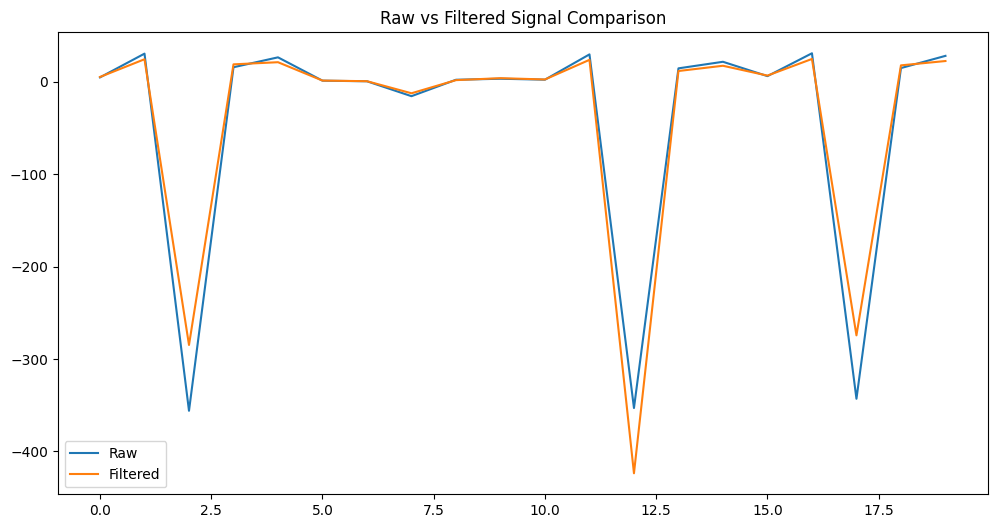

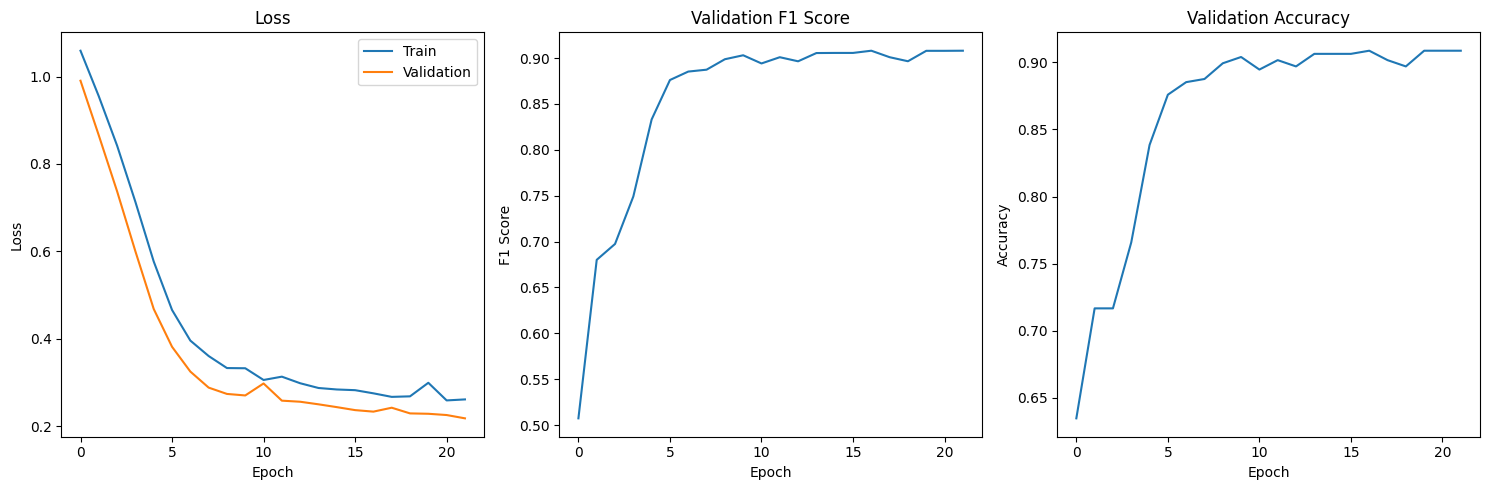

Confusion matrix saved to /content/drive/MyDrive/data/confusion_matrix.png


<Figure size 800x600 with 0 Axes>

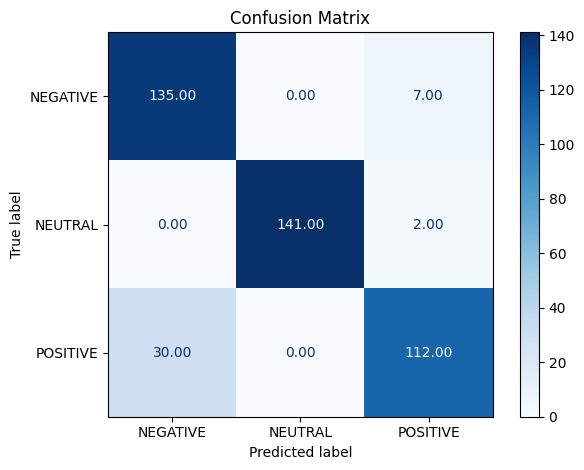

In [17]:
if __name__ == "__main__":
   train_model()

# Define NN Model(have Batch Normalization)

In [18]:
class TinyTSceptionWithNormalization(nn.Module):
    def __init__(self, feat_dim, classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(16),  # Batch Normalization
            nn.Conv2d(16, 32, kernel_size=(1, 15), padding=(0, 7)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(32, classes)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # output
        return self.fc(x)  # Output classification results

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TinyTSceptionWithNormalization(input_dim, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_f1 = 0.0
best_acc = 0.0
EPOCHS = 50

for epoch in range(1, EPOCHS + 1):
    model.train()
    for xb, yb in tqdm(dl_tr, desc=f"Epoch {epoch:02d} [train]"):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

    model.eval()
    preds, gold = [], []
    with torch.no_grad():
        for xb, yb in dl_val:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds.extend(logits.argmax(1).cpu().numpy())
            gold.extend(yb.cpu().numpy())

    val_f1 = f1_score(gold, preds, average='macro')
    val_acc = accuracy_score(gold, preds)
    print(f"Epoch {epoch:02d}  val_acc={val_acc:.3f}  val_f1={val_f1:.3f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_acc = val_acc
        torch.save(model.state_dict(), os.path.join(project_dir, 'best_day2.pth'))
        print("New best model saved")

print(f"Best validation accuracy: {best_acc:.3f}")
print(f"Best validation F1 score: {best_f1:.3f}")

Epoch 01 [train]: 100%|██████████| 27/27 [00:00<00:00, 111.90it/s]


Epoch 01  val_acc=0.888  val_f1=0.886
New best model saved


Epoch 02 [train]: 100%|██████████| 27/27 [00:00<00:00, 157.15it/s]


Epoch 02  val_acc=0.883  val_f1=0.880


Epoch 03 [train]: 100%|██████████| 27/27 [00:00<00:00, 171.09it/s]


Epoch 03  val_acc=0.888  val_f1=0.885


Epoch 04 [train]: 100%|██████████| 27/27 [00:00<00:00, 167.55it/s]


Epoch 04  val_acc=0.897  val_f1=0.895
New best model saved


Epoch 05 [train]: 100%|██████████| 27/27 [00:00<00:00, 114.11it/s]


Epoch 05  val_acc=0.911  val_f1=0.910
New best model saved


Epoch 06 [train]: 100%|██████████| 27/27 [00:00<00:00, 143.87it/s]


Epoch 06  val_acc=0.920  val_f1=0.920
New best model saved


Epoch 07 [train]: 100%|██████████| 27/27 [00:00<00:00, 139.57it/s]


Epoch 07  val_acc=0.916  val_f1=0.915


Epoch 08 [train]: 100%|██████████| 27/27 [00:00<00:00, 150.81it/s]


Epoch 08  val_acc=0.932  val_f1=0.932
New best model saved


Epoch 09 [train]: 100%|██████████| 27/27 [00:00<00:00, 151.70it/s]


Epoch 09  val_acc=0.932  val_f1=0.932


Epoch 10 [train]: 100%|██████████| 27/27 [00:00<00:00, 143.95it/s]


Epoch 10  val_acc=0.930  val_f1=0.929


Epoch 11 [train]: 100%|██████████| 27/27 [00:00<00:00, 148.71it/s]


Epoch 11  val_acc=0.939  val_f1=0.939
New best model saved


Epoch 12 [train]: 100%|██████████| 27/27 [00:00<00:00, 147.03it/s]


Epoch 12  val_acc=0.944  val_f1=0.943
New best model saved


Epoch 13 [train]: 100%|██████████| 27/27 [00:00<00:00, 118.19it/s]


Epoch 13  val_acc=0.948  val_f1=0.948
New best model saved


Epoch 14 [train]: 100%|██████████| 27/27 [00:00<00:00, 169.91it/s]


Epoch 14  val_acc=0.939  val_f1=0.939


Epoch 15 [train]: 100%|██████████| 27/27 [00:00<00:00, 166.71it/s]


Epoch 15  val_acc=0.946  val_f1=0.946


Epoch 16 [train]: 100%|██████████| 27/27 [00:00<00:00, 140.18it/s]


Epoch 16  val_acc=0.930  val_f1=0.930


Epoch 17 [train]: 100%|██████████| 27/27 [00:00<00:00, 169.84it/s]


Epoch 17  val_acc=0.941  val_f1=0.941


Epoch 18 [train]: 100%|██████████| 27/27 [00:00<00:00, 122.41it/s]


Epoch 18  val_acc=0.951  val_f1=0.951
New best model saved


Epoch 19 [train]: 100%|██████████| 27/27 [00:00<00:00, 133.52it/s]


Epoch 19  val_acc=0.953  val_f1=0.953
New best model saved


Epoch 20 [train]: 100%|██████████| 27/27 [00:00<00:00, 100.61it/s]


Epoch 20  val_acc=0.963  val_f1=0.962
New best model saved


Epoch 21 [train]: 100%|██████████| 27/27 [00:00<00:00, 130.24it/s]


Epoch 21  val_acc=0.960  val_f1=0.960


Epoch 22 [train]: 100%|██████████| 27/27 [00:00<00:00, 170.52it/s]


Epoch 22  val_acc=0.948  val_f1=0.948


Epoch 23 [train]: 100%|██████████| 27/27 [00:00<00:00, 167.48it/s]


Epoch 23  val_acc=0.958  val_f1=0.958


Epoch 24 [train]: 100%|██████████| 27/27 [00:00<00:00, 167.44it/s]


Epoch 24  val_acc=0.946  val_f1=0.946


Epoch 25 [train]: 100%|██████████| 27/27 [00:00<00:00, 133.04it/s]


Epoch 25  val_acc=0.958  val_f1=0.958


Epoch 26 [train]: 100%|██████████| 27/27 [00:00<00:00, 137.77it/s]


Epoch 26  val_acc=0.965  val_f1=0.965
New best model saved


Epoch 27 [train]: 100%|██████████| 27/27 [00:00<00:00, 111.56it/s]


Epoch 27  val_acc=0.960  val_f1=0.960


Epoch 28 [train]: 100%|██████████| 27/27 [00:00<00:00, 128.89it/s]


Epoch 28  val_acc=0.960  val_f1=0.960


Epoch 29 [train]: 100%|██████████| 27/27 [00:00<00:00, 146.17it/s]


Epoch 29  val_acc=0.963  val_f1=0.962


Epoch 30 [train]: 100%|██████████| 27/27 [00:00<00:00, 141.32it/s]


Epoch 30  val_acc=0.960  val_f1=0.960


Epoch 31 [train]: 100%|██████████| 27/27 [00:00<00:00, 167.99it/s]


Epoch 31  val_acc=0.960  val_f1=0.960


Epoch 32 [train]: 100%|██████████| 27/27 [00:00<00:00, 165.89it/s]


Epoch 32  val_acc=0.963  val_f1=0.962


Epoch 33 [train]: 100%|██████████| 27/27 [00:00<00:00, 130.49it/s]


Epoch 33  val_acc=0.963  val_f1=0.962


Epoch 34 [train]: 100%|██████████| 27/27 [00:00<00:00, 159.52it/s]


Epoch 34  val_acc=0.965  val_f1=0.965


Epoch 35 [train]: 100%|██████████| 27/27 [00:00<00:00, 129.51it/s]


Epoch 35  val_acc=0.965  val_f1=0.965


Epoch 36 [train]: 100%|██████████| 27/27 [00:00<00:00, 120.28it/s]


Epoch 36  val_acc=0.965  val_f1=0.965


Epoch 37 [train]: 100%|██████████| 27/27 [00:00<00:00, 159.75it/s]


Epoch 37  val_acc=0.960  val_f1=0.960


Epoch 38 [train]: 100%|██████████| 27/27 [00:00<00:00, 159.42it/s]


Epoch 38  val_acc=0.965  val_f1=0.965
New best model saved


Epoch 39 [train]: 100%|██████████| 27/27 [00:00<00:00, 81.55it/s]


Epoch 39  val_acc=0.970  val_f1=0.970
New best model saved


Epoch 40 [train]: 100%|██████████| 27/27 [00:00<00:00, 61.04it/s]


Epoch 40  val_acc=0.970  val_f1=0.969


Epoch 41 [train]: 100%|██████████| 27/27 [00:00<00:00, 65.31it/s]


Epoch 41  val_acc=0.965  val_f1=0.965


Epoch 42 [train]: 100%|██████████| 27/27 [00:00<00:00, 63.85it/s]


Epoch 42  val_acc=0.963  val_f1=0.962


Epoch 43 [train]: 100%|██████████| 27/27 [00:00<00:00, 58.40it/s]


Epoch 43  val_acc=0.967  val_f1=0.967


Epoch 44 [train]: 100%|██████████| 27/27 [00:00<00:00, 71.30it/s]


Epoch 44  val_acc=0.967  val_f1=0.967


Epoch 45 [train]: 100%|██████████| 27/27 [00:00<00:00, 88.67it/s]


Epoch 45  val_acc=0.967  val_f1=0.967


Epoch 46 [train]: 100%|██████████| 27/27 [00:00<00:00, 104.33it/s]


Epoch 46  val_acc=0.967  val_f1=0.967


Epoch 47 [train]: 100%|██████████| 27/27 [00:00<00:00, 97.79it/s] 


Epoch 47  val_acc=0.974  val_f1=0.974
New best model saved


Epoch 48 [train]: 100%|██████████| 27/27 [00:00<00:00, 72.59it/s]


Epoch 48  val_acc=0.970  val_f1=0.970


Epoch 49 [train]: 100%|██████████| 27/27 [00:00<00:00, 121.70it/s]


Epoch 49  val_acc=0.963  val_f1=0.962


Epoch 50 [train]: 100%|██████████| 27/27 [00:00<00:00, 152.58it/s]


Epoch 50  val_acc=0.963  val_f1=0.962
Best validation accuracy: 0.974
Best validation F1 score: 0.974


In [20]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels):
        super(ChannelAttention, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // 4),
            nn.ReLU(),
            nn.Linear(in_channels // 4, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):

        attention_weights = self.fc(x.mean(dim=[2, 3]))
        attention_weights = attention_weights.unsqueeze(2).unsqueeze(3)
        return x * attention_weights

In [21]:
class TinyTSceptionWithAttention(nn.Module):
    def __init__(self, feat_dim, classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(1, 15), padding=(0, 7)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.attention = ChannelAttention(32)
        self.fc = nn.Linear(32, classes)

    def forward(self, x):
        x = self.conv(x)
        x = self.attention(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [22]:
model = TinyTSceptionWithAttention(input_dim, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
best_f1 = 0.0
EPOCHS  = 50

for epoch in range(1, EPOCHS + 1):
  # ---- Train ----
  model.train()
  for xb, yb in tqdm(dl_tr, desc=f"Epoch {epoch:02d} [train]"):
    xb, yb = xb.to(device), yb.to(device)
    optimizer.zero_grad()
    loss = criterion(model(xb), yb)
    loss.backward()
    optimizer.step()

  # ---- Validate ----
  model.eval()
  preds, gold = [], []
  with torch.no_grad():
    for xb, yb in dl_val:
      xb, yb = xb.to(device), yb.to(device)
      logits = model(xb)
      preds.extend(logits.argmax(1).cpu().numpy())
      gold.extend(yb.cpu().numpy())

  val_f1  = f1_score(gold, preds, average='macro')
  val_acc = accuracy_score(gold, preds)
  print(f"Epoch {epoch:02d}  val_acc={val_acc:.3f}  val_f1={val_f1:.3f}")

  if val_f1 > best_f1:
    best_f1 = val_f1
    torch.save(model.state_dict(), os.path.join(project_dir, 'best_day2.pth'))
    print("New best model saved")

Epoch 01 [train]: 100%|██████████| 27/27 [00:00<00:00, 188.02it/s]


Epoch 01  val_acc=0.492  val_f1=0.402
New best model saved


Epoch 02 [train]: 100%|██████████| 27/27 [00:00<00:00, 160.18it/s]


Epoch 02  val_acc=0.719  val_f1=0.670
New best model saved


Epoch 03 [train]: 100%|██████████| 27/27 [00:00<00:00, 169.31it/s]


Epoch 03  val_acc=0.689  val_f1=0.640


Epoch 04 [train]: 100%|██████████| 27/27 [00:00<00:00, 194.97it/s]


Epoch 04  val_acc=0.719  val_f1=0.690
New best model saved


Epoch 05 [train]: 100%|██████████| 27/27 [00:00<00:00, 190.71it/s]


Epoch 05  val_acc=0.838  val_f1=0.835
New best model saved


Epoch 06 [train]: 100%|██████████| 27/27 [00:00<00:00, 188.18it/s]


Epoch 06  val_acc=0.859  val_f1=0.857
New best model saved


Epoch 07 [train]: 100%|██████████| 27/27 [00:00<00:00, 101.40it/s]


Epoch 07  val_acc=0.874  val_f1=0.872
New best model saved


Epoch 08 [train]: 100%|██████████| 27/27 [00:00<00:00, 143.04it/s]


Epoch 08  val_acc=0.883  val_f1=0.883
New best model saved


Epoch 09 [train]: 100%|██████████| 27/27 [00:00<00:00, 174.72it/s]

Epoch 09  val_acc=0.899  val_f1=0.899


New best model saved


Epoch 10 [train]: 100%|██████████| 27/27 [00:00<00:00, 185.06it/s]


Epoch 10  val_acc=0.906  val_f1=0.906
New best model saved


Epoch 11 [train]: 100%|██████████| 27/27 [00:00<00:00, 198.62it/s]


Epoch 11  val_acc=0.899  val_f1=0.899


Epoch 12 [train]: 100%|██████████| 27/27 [00:00<00:00, 161.93it/s]


Epoch 12  val_acc=0.906  val_f1=0.906


Epoch 13 [train]: 100%|██████████| 27/27 [00:00<00:00, 177.62it/s]


Epoch 13  val_acc=0.909  val_f1=0.908
New best model saved


Epoch 14 [train]: 100%|██████████| 27/27 [00:00<00:00, 189.27it/s]


Epoch 14  val_acc=0.909  val_f1=0.908


Epoch 15 [train]: 100%|██████████| 27/27 [00:00<00:00, 132.63it/s]


Epoch 15  val_acc=0.911  val_f1=0.910
New best model saved


Epoch 16 [train]: 100%|██████████| 27/27 [00:00<00:00, 167.00it/s]


Epoch 16  val_acc=0.911  val_f1=0.911
New best model saved


Epoch 17 [train]: 100%|██████████| 27/27 [00:00<00:00, 91.75it/s]


Epoch 17  val_acc=0.909  val_f1=0.908


Epoch 18 [train]: 100%|██████████| 27/27 [00:00<00:00, 120.76it/s]


Epoch 18  val_acc=0.913  val_f1=0.913
New best model saved


Epoch 19 [train]: 100%|██████████| 27/27 [00:00<00:00, 113.52it/s]


Epoch 19  val_acc=0.913  val_f1=0.913
New best model saved


Epoch 20 [train]: 100%|██████████| 27/27 [00:00<00:00, 116.29it/s]


Epoch 20  val_acc=0.913  val_f1=0.913


Epoch 21 [train]: 100%|██████████| 27/27 [00:00<00:00, 164.27it/s]

Epoch 21  val_acc=0.916  val_f1=0.915


New best model saved


Epoch 22 [train]: 100%|██████████| 27/27 [00:00<00:00, 191.74it/s]


Epoch 22  val_acc=0.913  val_f1=0.913


Epoch 23 [train]: 100%|██████████| 27/27 [00:00<00:00, 202.35it/s]


Epoch 23  val_acc=0.913  val_f1=0.913


Epoch 24 [train]: 100%|██████████| 27/27 [00:00<00:00, 201.07it/s]


Epoch 24  val_acc=0.883  val_f1=0.883


Epoch 25 [train]: 100%|██████████| 27/27 [00:00<00:00, 197.83it/s]


Epoch 25  val_acc=0.916  val_f1=0.915


Epoch 26 [train]: 100%|██████████| 27/27 [00:00<00:00, 169.44it/s]


Epoch 26  val_acc=0.911  val_f1=0.911


Epoch 27 [train]: 100%|██████████| 27/27 [00:00<00:00, 149.80it/s]


Epoch 27  val_acc=0.916  val_f1=0.915
New best model saved


Epoch 28 [train]: 100%|██████████| 27/27 [00:00<00:00, 162.39it/s]


Epoch 28  val_acc=0.916  val_f1=0.915


Epoch 29 [train]: 100%|██████████| 27/27 [00:00<00:00, 150.16it/s]


Epoch 29  val_acc=0.918  val_f1=0.918
New best model saved


Epoch 30 [train]: 100%|██████████| 27/27 [00:00<00:00, 180.04it/s]


Epoch 30  val_acc=0.913  val_f1=0.913


Epoch 31 [train]: 100%|██████████| 27/27 [00:00<00:00, 162.03it/s]


Epoch 31  val_acc=0.916  val_f1=0.915


Epoch 32 [train]: 100%|██████████| 27/27 [00:00<00:00, 129.16it/s]


Epoch 32  val_acc=0.920  val_f1=0.920
New best model saved


Epoch 33 [train]: 100%|██████████| 27/27 [00:00<00:00, 131.07it/s]


Epoch 33  val_acc=0.916  val_f1=0.915


Epoch 34 [train]: 100%|██████████| 27/27 [00:00<00:00, 172.68it/s]


Epoch 34  val_acc=0.920  val_f1=0.920
New best model saved


Epoch 35 [train]: 100%|██████████| 27/27 [00:00<00:00, 160.31it/s]


Epoch 35  val_acc=0.918  val_f1=0.917


Epoch 36 [train]: 100%|██████████| 27/27 [00:00<00:00, 146.34it/s]


Epoch 36  val_acc=0.897  val_f1=0.897


Epoch 37 [train]: 100%|██████████| 27/27 [00:00<00:00, 213.36it/s]


Epoch 37  val_acc=0.920  val_f1=0.920


Epoch 38 [train]: 100%|██████████| 27/27 [00:00<00:00, 226.14it/s]


Epoch 38  val_acc=0.920  val_f1=0.920


Epoch 39 [train]: 100%|██████████| 27/27 [00:00<00:00, 227.78it/s]


Epoch 39  val_acc=0.904  val_f1=0.904


Epoch 40 [train]: 100%|██████████| 27/27 [00:00<00:00, 228.06it/s]


Epoch 40  val_acc=0.923  val_f1=0.922
New best model saved


Epoch 41 [train]: 100%|██████████| 27/27 [00:00<00:00, 226.36it/s]


Epoch 41  val_acc=0.925  val_f1=0.925
New best model saved


Epoch 42 [train]: 100%|██████████| 27/27 [00:00<00:00, 218.44it/s]


Epoch 42  val_acc=0.923  val_f1=0.922


Epoch 43 [train]: 100%|██████████| 27/27 [00:00<00:00, 224.07it/s]


Epoch 43  val_acc=0.925  val_f1=0.925


Epoch 44 [train]: 100%|██████████| 27/27 [00:00<00:00, 224.27it/s]


Epoch 44  val_acc=0.925  val_f1=0.925


Epoch 45 [train]: 100%|██████████| 27/27 [00:00<00:00, 225.98it/s]


Epoch 45  val_acc=0.923  val_f1=0.922


Epoch 46 [train]: 100%|██████████| 27/27 [00:00<00:00, 227.58it/s]


Epoch 46  val_acc=0.927  val_f1=0.927
New best model saved


Epoch 47 [train]: 100%|██████████| 27/27 [00:00<00:00, 206.61it/s]


Epoch 47  val_acc=0.909  val_f1=0.909


Epoch 48 [train]: 100%|██████████| 27/27 [00:00<00:00, 222.34it/s]


Epoch 48  val_acc=0.930  val_f1=0.929
New best model saved


Epoch 49 [train]: 100%|██████████| 27/27 [00:00<00:00, 213.38it/s]


Epoch 49  val_acc=0.927  val_f1=0.927


Epoch 50 [train]: 100%|██████████| 27/27 [00:00<00:00, 218.91it/s]


Epoch 50  val_acc=0.932  val_f1=0.932
New best model saved
